In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Compress to latent_dim
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # Output values in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train Autoencoder
def train_autoencoder(model, dataloader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for imgs, _ in dataloader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model

# Run everything
model = Autoencoder()
trained_model = train_autoencoder(model, data_loader, epochs=10)

Epoch [1/10], Loss: 0.0391
Epoch [2/10], Loss: 0.0284
Epoch [3/10], Loss: 0.0222
Epoch [4/10], Loss: 0.0223
Epoch [5/10], Loss: 0.0200
Epoch [6/10], Loss: 0.0170
Epoch [7/10], Loss: 0.0185
Epoch [8/10], Loss: 0.0153
Epoch [9/10], Loss: 0.0166
Epoch [10/10], Loss: 0.0156


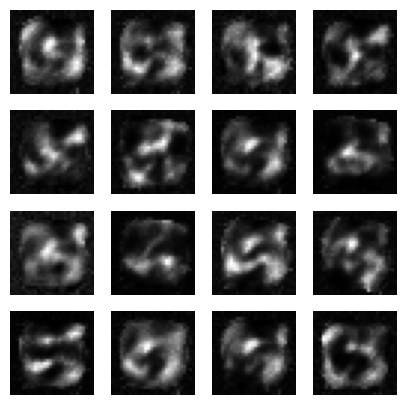

In [36]:
# Generate random images from learned latent space
def generate_images(model, num_samples=16, latent_dim=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)  # Sample from normal distribution
        generated_images = model.decoder(random_latent_vectors).cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap="gray")
        ax.axis("off")
    plt.show()

generate_images(trained_model)

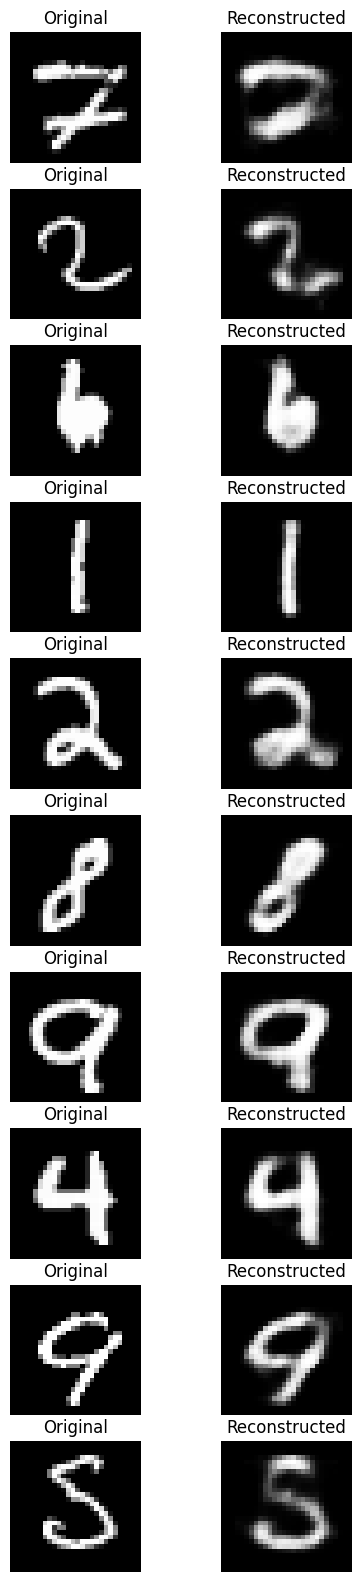

In [23]:
import torch
import matplotlib.pyplot as plt

def evaluate_autoencoder_on_real_data(autoencoder, dataloader, num_samples=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device).eval()

    # Get a batch of real MNIST images
    images, _ = next(iter(dataloader))
    images = images[:num_samples].view(num_samples, -1).to(device)

    # Encode and decode the images
    with torch.no_grad():
        reconstructed_images = autoencoder(images).cpu().numpy()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(num_samples, 2, figsize=(5, num_samples * 2))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Reconstructed")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    plt.show()

# Evaluate the trained autoencoder on real MNIST data
evaluate_autoencoder_on_real_data(trained_model, data_loader)

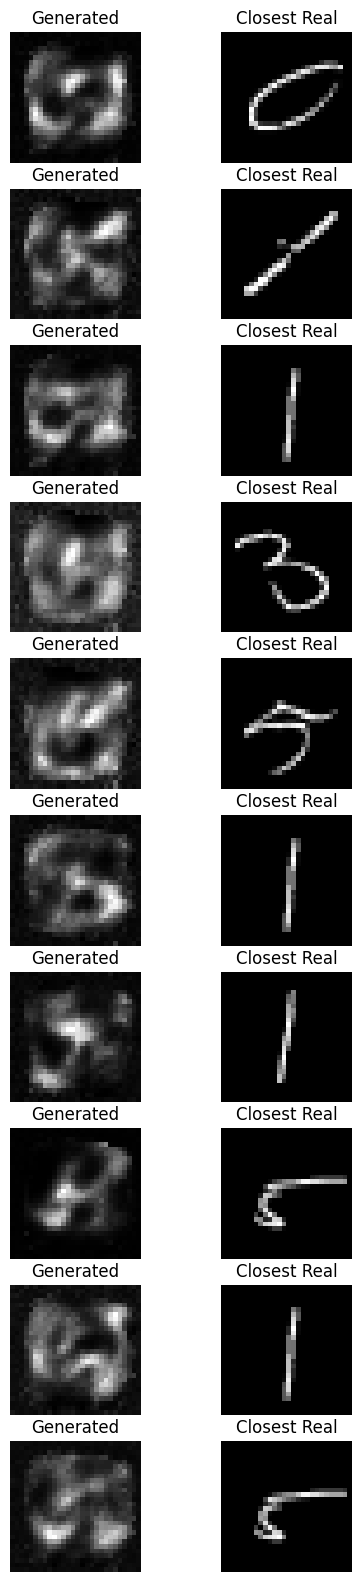

In [22]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def get_mnist_data():
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    images, _ = next(iter(dataloader))
    return images.view(len(dataset), -1).numpy()  # Flatten images

def mse_distance(img1, img2):
    return np.mean((img1 - img2) ** 2)

def find_closest_images(autoencoder, num_samples=10, latent_dim=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device).eval()

    # Get real MNIST images
    mnist_images = get_mnist_data()

    # Generate random images from latent space
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)
        generated_images = autoencoder.decoder(random_latent_vectors).cpu().numpy()

    # Find closest real image for each generated image
    closest_images = []
    for gen_img in generated_images:
        distances = [mse_distance(gen_img, real_img) for real_img in mnist_images]
        closest_idx = np.argmin(distances)
        closest_images.append(mnist_images[closest_idx])

    # Plot generated vs. closest real images
    fig, axes = plt.subplots(num_samples, 2, figsize=(5, num_samples * 2))
    for i in range(num_samples):
        axes[i, 0].imshow(generated_images[i].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title("Generated")
        axes[i, 1].imshow(closest_images[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Closest Real")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    plt.show()

# Example usage (Assumes `autoencoder` model is already trained)
find_closest_images(trained_model)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu = nn.Linear(64, latent_dim)  # Mean
        self.logvar = nn.Linear(64, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.mu(encoded), self.logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Loss function (Reconstruction + KL Divergence)
def vae_loss_function(reconstructed_x, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Training function
def train_vae(model, dataloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            optimizer.zero_grad()
            reconstructed, mu, logvar = model(imgs)
            loss = vae_loss_function(reconstructed, imgs, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")
    return model

# Train the VAE
vae_model = VAE()
vae_trained_model = train_vae(vae_model, data_loader, epochs=10)

Epoch [1/10], Loss: 3249375.9243
Epoch [2/10], Loss: 2500681.7930
Epoch [3/10], Loss: 2201217.7798
Epoch [4/10], Loss: 2069860.2864
Epoch [5/10], Loss: 2006137.2444
Epoch [6/10], Loss: 1969450.9797
Epoch [7/10], Loss: 1941731.1018
Epoch [8/10], Loss: 1919112.6792
Epoch [9/10], Loss: 1902176.7422
Epoch [10/10], Loss: 1888521.6487


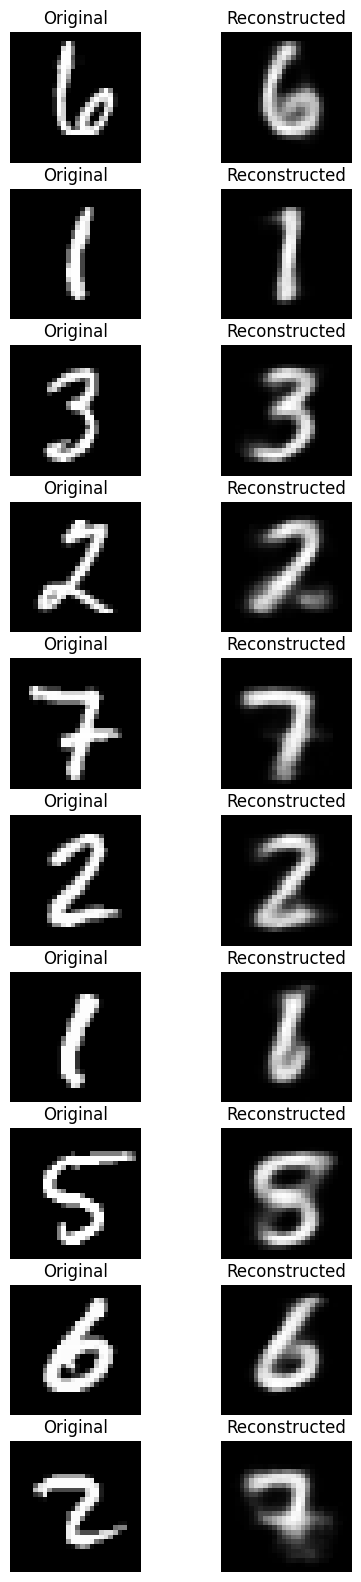

In [41]:
import torch
import matplotlib.pyplot as plt

def evaluate_vae_reconstruction(vae, dataloader, num_samples=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()

    # Get a batch of real MNIST images
    images, _ = next(iter(dataloader))
    images = images[:num_samples].view(num_samples, -1).to(device)

    # Encode and decode the images
    with torch.no_grad():
        reconstructed_images, _, _ = vae(images)
        reconstructed_images = reconstructed_images.cpu().numpy()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(num_samples, 2, figsize=(5, num_samples * 2))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Reconstructed")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    plt.show()

# Evaluate VAE reconstruction
evaluate_vae_reconstruction(vae_trained_model, data_loader)

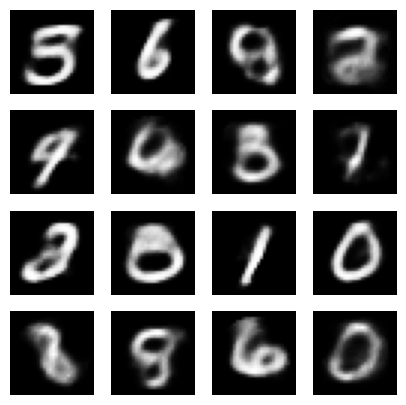

In [46]:
import torch
import matplotlib.pyplot as plt

def generate_images_vae(vae, num_samples=16, latent_dim=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()

    # Generate random latent vectors from a normal distribution
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)
        generated_images = vae.decoder(random_latent_vectors).cpu().numpy()

    # Plot generated images
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()

# Generate random samples from VAE
generate_images_vae(vae_trained_model)

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

def get_digit_subset(dataloader, vae, digit=0, num_samples=1000):
    """Extracts all images of a specific digit from the dataset and encodes them using VAE."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()
    digit_images = []
    for images, labels in dataloader:
        mask = labels == digit
        digit_images.append(images[mask])
        if len(torch.cat(digit_images)) >= num_samples:
            break
    digit_images = torch.cat(digit_images)[:num_samples].to(device)  # Take subset and move to device

    # Encode the images using the VAE encoder
    with torch.no_grad():
        encoded_images = vae.encoder(digit_images.view(num_samples, -1))

    return encoded_images.cpu().numpy()  # Convert back to numpy

def sample_from_convex_hull(hull, num_samples=16):
    """Generates random points inside the convex hull."""
    points = hull.points
    dim = points.shape[1]
    rand_weights = np.random.dirichlet(alpha=np.ones(len(points)), size=num_samples)
    sampled_points = np.dot(rand_weights, points)  # Convex combination of hull points
    return sampled_points

def decode_and_plot_images(vae, sampled_points):
    """Decodes sampled latent points into images and plots them."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()
    sampled_tensors = torch.tensor(sampled_points, dtype=torch.float32).to(device)

    with torch.no_grad():
        generated_images = vae.decoder(sampled_tensors).cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()

# Extract only digit 0 from dataset and encode using VAE
zero_latent_vectors = get_digit_subset(data_loader, vae_trained_model, digit=0, num_samples=1000)

# Compute convex hull around encoded 0s
hull = ConvexHull(zero_latent_vectors)

# Sample random points inside convex hull
sampled_latent_points = sample_from_convex_hull(hull, num_samples=16)

# Decode and plot sampled points
decode_and_plot_images(vae_trained_model, sampled_latent_points)


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qx Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 476462854  incidence  Qxact-merge  Qtriangulate  _zero-centrum
  Q3-no-merge-vertices-dim-high  _max-width 4.6  Error-roundoff 5.6e-13
  _one-merge 7.2e-11  _near-inside 3.6e-10  Visible-distance 3.4e-12
  U-max-coplanar 3.4e-12  Width-outside 6.7e-12  _wide-facet 2e-11
  _maxoutside 7.3e-11

precision problems (corrected unless 'Q0' or an error)
     65 nearly singular or axis-parallel hyperplanes
     65 zero divisors during back substitute
 510624 zero divisors during gaussian elimination

The input to qhull appears to be less than 64 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p61(v65):   3.2  0.77     0 0.043     1   1.7  0.29   1.7     0  0.43  0.79     0   1.2   1.6     0   2.2 0.055     0     0     0     0     0  0.63  0.61     0  0.89   2.9     0  0.42   1.8  0.89   1.5  0.86  0.64   1.9   2.1     0  0.68     1     0     0   1.5   1.1   1.7   1.2     2     0  0.51  0.96  0.25     0     0   2.8     0     0  0.37  0.98   0.6     0     0     0   1.4     0     0
- p60(v64):   3.3   1.2     0  0.55   1.3   1.5  0.25  0.99     0  0.88   1.5     0   1.5   1.2     0   3.5     0     0     0     0     0     0   1.7   1.8     0   1.5   1.2     0     0  0.11   1.5   3.1 0.033  0.56   1.5     2     0     1   2.9     0     0   0.9   1.1   1.1   1.2   2.6     0  0.27   1.2   1.3     0     0   1.3     0     0  0.11  0.84  0.61     0     0     0   1.1     0     0
- p59(v63):   3.5   1.3     0  0.91   1.6   1.8   0.3   1.1     0   1.4   1.4     0   1.6   1.5     0   3.8     0     0     0     0     0     0  0.85   1.9     0   1.3   2.1     0  0.15  0.98   2.5   2.3  0.34  0.93  0.18   2.9     0  0.47   1.7     0     0   1.7  0.77     1  0.57   2.1     0  0.44  0.84   1.3     0     0   2.2     0     0  0.18  0.49     0     0     0     0   1.7     0     0
- p58(v62):   3.7  0.66     0     0   1.8  0.33  0.59  0.61     0   1.8   1.9     0   1.3   1.9     0   3.4     0     0     0     0     0     0   1.1   2.1     0   1.8   2.9     0     1     0   1.5   2.5   1.3  0.52   1.6   2.5     0     1   3.2     0     0   1.3   1.7   1.5   1.4     1     0  0.14   1.6  0.95     0     0   1.4     0     0     1     1  0.34     0     0     0 0.093     0     0
- p57(v61):   3.1  0.78     0     0  0.78   1.4  0.48  0.77     0   1.1  0.69     0   1.3   1.2     0   3.6     0     0     0     0     0  0.95   1.3   1.9     0   1.8   1.9     0  0.64  0.21  0.68   2.1  0.39   1.5  0.12   1.5     0   1.2   2.3     0     0  0.73   1.3  0.92   1.5   1.7     0   0.3   1.7   1.5     0     0  0.88     0     0  0.72   1.6  0.22     0     0     0   1.8     0     0
- p56(v60):   2.4  0.41     0     0   1.5   1.2     0     0     0     2   1.6  0.11   3.5   1.3     0   2.3     0     0     0     0     0  0.18     1     2     0   1.3   2.2     0   1.8  0.38   1.9   2.1  0.62   1.2   1.1     3     0   1.1   2.1     0     0  0.68   1.2   1.2     0  0.48     0  0.22   1.3   1.2     0     0   1.5     0     0   1.1   1.2  0.76     0     0     0     0     0     0
- p55(v59):   3.3   1.3     0  0.19   1.8  0.47  0.71  0.51     0   1.7   1.2     0     2  0.78     0   3.4     0     0     0  0.68     0     0  0.78   2.4     0   1.7   1.5     0  0.79  0.63   2.3     2  0.54   1.7  0.33   2.9     0 0.086   1.3     0     0   2.7  0.99  0.45   1.5   1.3     0     0  0.85   1.6     0     0   1.7     0     0  0.29  0.69     0     0     0     0  0.98     0     0
- p54(v58):   2.5     1     0     1     1   1.6  0.23  0.83     0  0.82   1.7     0   1.5  0.69     0   2.2     0     0     0     0     0     0     1   1.1     0   1.6   1.5     0     0   1.2     1   1.9  0.26  0.95   2.2   2.7     0 0.0063   1.4     0     0   2.5   1.2  0.26   1.5   2.3     0  0.78  0.74  0.95     0     0   2.1     0     0 0.046  0.44   0.2     0     0     0     2     0     0
- p53(v57):   2.4  0.75     0     0  0.73   1.3  0.72  0.94     0  0.88  0.64     0   1.6  0.61     0   3.3     0     0     0     0     0  0.52     2     2     0   1.5  0.52     0     0 0.018  0.45   2.5     0   1.2   0.4  0.83     0   1.6   2.1     0     0  0.67  0.88  0.21   1.3   2.1     0  0.18     1   1.6     0     0  0.62     0     0  0.61   1.6     0     0     0     0   1.8     0     0
- p52(v56):   3.2   1.4     0 0.098   1.5  0.73  0.77  0.68     0   1.9  0.52     0   1.3  0.95     0   3.9     0     0     0  0.23     0  0.22  0.82   2.4     0   1.4   1.2     0  0.11  0.77   1.7   1.7  0.21   1.9     0     2     0     0  0.83     0     0   2.3  0.82 0.057   1.6     1     0     0  0.53   1.8     0     0   1.2     0     0  0.41  0.92     0     0     0     0   1.3     0     0
- p51(v55):   2.5  0.64     0     0  0.52   1.5  0.38  0.42     0   1.1  0.42     0   1.4  0.83     0   3.2     0     0     0     0     0   1.2   1.2   1.7     0   1.7   1.6     0  0.75  0.26  0.48   1.7  0.15   1.7     0   1.2     0   1.2   1.8     0     0  0.53   1.1  0.72   1.2   1.5     0  0.36   1.6   1.6     0     0  0.66     0     0   0.8   1.7  0.27     0     0     0   1.9     0     0
- p50(v54):   3.1  0.35     0     0  0.88   1.7  0.48   0.7     0  0.53   1.3     0     1   2.1     0   2.2     0     0     0     0     0  0.41   1.9  0.66     0  0.75   2.6     0  0.25  0.67   0.7   1.8  0.63 0.024   1.9   1.9     0   2.3   2.8     0     0     0   1.7   2.2   1.6   1.7     0  0.96   0.8  0.24     0     0   2.4     0     0  0.39  0.57   1.4     0     0     0  0.67     0     0
- p49(v53):   2.8  0.87     0     0   1.3  0.89   1.1   0.5     0   1.3  0.82     0   1.7  0.24     0   4.1     0     0     0     0     0  0.85   1.7   2.7     0   2.2  0.78     0  0.29     0     1   2.6     0   1.8   0.4   1.5     0     1   2.3     0     0   1.2     1  0.18   1.7   1.7     0     0   1.3   2.2     0     0  0.41     0     0  0.62   1.6     0     0     0     0   1.2     0     0
- p48(v52):     3   0.8     0     0   1.4  0.83  0.56     1     0  0.89   1.1     0   1.7   0.9     0   2.9     0     0     0     0     0     0  0.84     2     0   1.8   2.1     0  0.53  0.54   1.8   2.3  0.97   1.4   1.7   2.1     0  0.59     2     0     0     2  0.98  0.51   1.7   2.1     0  0.33   1.5   1.1     0     0   1.5     0     0  0.44   1.1  0.45     0     0     0   1.4     0     0
- p47(v51):   2.9 0.044     0     0  0.66   1.6   0.7  0.14     0   1.4  0.95     0   1.9   1.8     0   2.8     0     0     0     0     0   1.5   1.6   1.9     0   1.8   2.5     0   1.7  0.34  0.57   1.8   1.2   1.3  0.36     1     0   3.2     3     0     0     0   1.8   2.1  0.47  0.93     0   0.6   2.1   1.2     0     0  0.42     0     0   1.3   1.8   1.2     0     0     0   1.3     0     0
- p46(v50):   2.8  0.43     0     0  0.65   1.7  0.56   1.7     0   0.3  0.41     0   1.7   1.3     0   2.8     0     0     0     0     0  0.54  0.82   1.7     0   1.8   2.4     0  0.59   1.1  0.94   2.4   1.3   1.4   2.2  0.74     0   1.7   2.4     0     0  0.54   1.2  0.92   1.5   2.5     0  0.26   2.2  0.83     0     0  0.93     0     0  0.82     2   1.3     0     0     0   1.9     0     0
- p45(v49):   3.1   1.2     0  0.56   1.3  0.52   1.5  0.55     0   1.7     1     0     1  0.67     0   3.9     0     0     0  0.39     0   0.3   1.4   2.4     0   1.6  0.72     0  0.15  0.25   1.4   1.5 0.046   1.8     0   2.5     0 0.091   1.5     0     0   1.6   1.1 0.048   2.3   1.1     0 0.011  0.47   1.9     0     0   1.1     0     0     0  0.83     0     0     0     0   1.5     0     0
- p44(v48):   3.8  0.28     0     0   1.7   1.5  0.12  0.51     0   1.1   1.6     0   1.9   2.2     0     3     0     0     0     0     0  0.24   1.8   1.6     0  0.93   3.4     0   1.3  0.24   1.8   2.6   1.2     0   1.7   2.3     0   2.5   3.4     0     0     0   1.6   2.8  0.47     1     0  0.35   1.6  0.61     0     0   1.6     0     0  0.94   1.2   1.8     0     0     0     0     0     0
- p42(v47):     3  0.78     0     0   1.3  0.89  0.51  0.57     0   1.3   2.1     0   1.2   1.4     0   2.7     0     0     0     0     0     0   1.3   1.4     0   1.6   1.8     0  0.24  0.37   1.2   2.2  0.64  0.49   2.7   2.7     0  0.68   2.8     0     0   1.5   1.6     1   1.5   1.9     0  0.56   1.1  0.93     0     0   1.8     0     0  0.28  0.35  0.67     0     0     0  0.98     0     0
- p41(v46):   2.7  0.69     0     0   1.2   1.6 0.078  0.92     0   1.2   1.6     0   1.7   1.2     0   2.1     0     0     0     0     0     0   0.8  0.99     0   1.3   2.7     0  0.68   1.5   1.1   1.7   0.8  0.62   3.4   2.8     0   0.3   1.7     0     0   1.8   1.4   1.1  0.54   1.8     0  0.43   1.1  0.78     0     0   2.2     0     0  0.51  0.76   1.7     0     0     0  0.88     0     0
- p40(v45):   1.9 0.088     0     0 0.059   2.3  0.53  0.82     0     0  0.52     0   2.3   1.2     0   1.1  0.31     0     0     0     0  0.68  0.82  0.25     0  0.93   2.4     0  0.45     2   1.1   1.3  0.99   1.1   2.8   1.2     0   2.1   1.4     0     0     0  0.85   1.4  0.44   2.4     0  0.82   1.3     0     0     0   1.7     0     0  0.21   1.1   2.4     0     0     0   1.8     0     0
- p39(v44):     3  0.77     0     0   1.2     1  0.57  0.77     0  0.87  0.79     0   1.6  0.62     0   3.8     0     0     0     0     0   0.8   1.5   2.3     0   2.3   1.4     0   0.5     0  0.81     3  0.37   1.6   1.1   1.1     0   1.2   2.9     0     0  0.89   1.4  0.59   1.8     2     0     0   1.7   1.9     0     0  0.52     0     0  0.77   1.7  0.53     0     0     0   1.3     0     0
- p38(v43):   2.3  0.68     0     0  0.71   1.1   1.2  0.11     0     2  0.87     0   1.2   1.4     0   3.5     0     0     0     0     0   1.9   2.5   2.3     0   1.5   1.8     0  0.72     0     0   1.7     0   1.6     0  0.61     0   2.2   2.2     0     0     0   1.1  0.73  0.61  0.82     0  0.35   1.3   1.7     0     0  0.26 0.019     0   1.7   2.6     0     0     0     0   1.4     0     0
- p37(v42):   1.8     0     0     0  0.44   1.5  0.34  0.58     0  0.76  0.52     0   2.6   1.3     0   1.1   0.4     0     0     0     0  0.52  0.66  0.59     0  0.91     3     0   1.1   1.9     1   1.1     1  0.76   3.2   1.5     0   1.8   1.2     0     0 0.067  0.96   1.7     0   1.7     0  0.58   1.2  0.28     0     0   1.4     0     0  0.74   1.2     2     0     0     0  0.93     0     0
- p36(v41):   3.1  0.87     0     0   1.4  0.74   1.3  0.18     0   1.8  0.99     0   1.3   0.7     0   4.2     0     0     0     0     0   1.3   1.8   2.7     0   2.2   1.2     0  0.73     0  0.87     2  0.15   2.2     0   1.5     0   1.1   2.3     0     0     1   1.5  0.33   2.2     1     0     0   1.3   2.3     0     0  0.57     0     0  0.72   1.6     0     0     0     0   1.5     0     0
- p35(v40):   2.3  0.72     0     0  0.76   1.9  0.54 0.078     0   1.5  0.89     0   1.8  0.86     0     3     0     0     0     0     0     1   2.1     2     0   1.2  0.67     0   0.2     0  0.44     2     0   1.2     0   1.3     0   1.9   1.9     0     0     0  0.85  0.77  0.42   1.4     0  0.29  0.88   1.8     0     0  0.42     0     0  0.64   1.5   0.1     0     0     0   1.3     0     0
- p34(v39):   3.1  0.53     0     0  0.89   2.3  0.25   1.1     0  0.89  0.95     0   1.6   1.8     0   2.5     0     0     0     0     0  0.52   1.4   1.2     0  0.91   2.6     0  0.68   1.3   1.1   1.8   0.8  0.79   2.4   1.7     0     2   2.1     0     0     0   1.2     2  0.68     2     0  0.58   1.4   0.7     0     0   1.8     0     0  0.56   1.3   1.6     0     0     0   1.1     0     0
- p33(v38):   2.6  0.85     0     0   1.5   1.3  0.12  0.56     0   1.5   1.8     0   2.5   1.3     0   1.9     0     0     0     0     0     0   0.6   1.4     0   1.4   2.5     0     1   1.5   1.4   1.7  0.74  0.88     2   3.3     0 0.082   1.2     0     0   2.3   1.4  0.85   0.5   1.2     0  0.39  0.64     1     0     0   2.5     0     0  0.48  0.52  0.72     0     0     0  0.56     0     0
- p32(v37):   3.3   1.1     0 0.054   1.6  0.76   0.8   1.2     0  0.83  0.97     0   1.4  0.53     0   4.1     0     0     0     0     0  0.25   1.5   2.3     0   2.1   1.3     0     0   0.3   1.3     3  0.27   1.6  0.91   1.6     0  0.49   2.1     0     0   2.2   1.2  0.05   2.6   2.2     0 0.0039   1.3   1.7     0     0   1.2     0     0  0.34   1.4     0     0     0     0   1.8     0     0
- p31(v36):   4.1   1.1     0     0   1.9   1.2  0.45     0     0   2.8     2     0     2   2.9     0     4     0     0     0     0     0  0.64   1.4     3     0   1.7   3.2     0   1.3 0.095     2     2   0.9     1     0   3.5     0   1.4     3     0     0   1.1   1.9   1.7  0.91  0.28     0  0.55   1.2   1.5     0     0   1.8     0     0   1.2  0.77     0     0     0     0  0.12     0     0
- p30(v35):   1.3   1.3     0  0.04   1.2   1.1  0.91     0     0   2.1  0.94     0     2   1.1     0     2     0     0     0  0.38     0  0.46  0.27   1.8     0   1.1  0.84     0  0.78  0.72   1.5  0.34  0.24   1.6     0   2.3     0     0  0.15     0     0  0.83  0.57     0  0.05   0.3     0  0.55 0.093   1.6     0     0   1.4     0     0  0.49  0.14     0     0     0     0  0.94     0     0
- p29(v34):   3.4  0.93     0  0.49   1.1   2.1  0.25   1.2     0  0.49   1.6     0  0.99   1.7     0   2.9     0     0     0     0     0     0   1.9     1     0   1.2   1.8     0     0  0.41   1.1   2.5  0.32  0.38   1.9     2     0   1.5   3.1     0     0  0.54   1.4   1.6   1.7   2.7     0  0.79   1.2  0.51     0     0   1.9     0     0     0  0.42   1.1     0     0     0   1.6     0     0
- p28(v33):   2.5 0.027     0     0  0.46   2.1  0.45     1     0  0.83   0.5     0   2.1   1.6     0   2.3     0     0     0     0     0  0.89     1   1.5     0   1.4   2.3     0   1.1   1.3   1.1   1.8   1.2   1.3   1.9  0.82     0   2.6   2.2     0     0     0   1.2   1.8  0.22   1.9     0  0.32   2.1  0.83     0     0   0.5     0     0  0.93   1.8   1.9     0     0     0   1.4     0     0
- p27(v32):   3.2  0.15     0     0  0.56   1.8  0.33   1.2     0   1.1   0.4     0   1.7     2     0   3.1     0     0     0     0     0   1.1  0.81   1.8     0   1.4   2.9     0   1.3   1.1     1     2   1.4   1.3  0.45  0.66     0   2.4   2.2     0     0     0   1.1   2.1  0.41   1.5     0  0.13   2.3  0.61     0     0  0.65     0     0   1.2     2   1.3     0     0     0   1.5     0     0
- p26(v31):   1.9  0.41     0 0.057  0.35   2.3  0.32   1.3     0  0.15  0.61     0   1.9   1.1     0   1.4     0     0     0     0     0  0.35  0.71  0.94     0   1.2   1.7     0  0.29   1.7   1.1   1.6  0.89   1.2   2.4     1     0   1.4   1.2     0     0  0.57   0.7  0.63   0.7   2.5     0  0.59   1.4  0.32     0     0   1.2     0     0   0.3   1.4   1.6     0     0     0   2.2     0     0
- p25(v30):   2.6  0.71     0     0  0.71   1.4  0.53     1     0  0.92     0     0   1.7  0.32     0   3.7     0     0     0     0     0  0.93   1.1     2     0   1.5   1.2     0  0.19  0.51  0.76   2.4     0     2     0  0.63     0  0.87   1.4     0     0   1.1  0.68   0.1   1.3   1.8     0     0   1.3   1.9     0     0  0.55     0     0  0.81   2.2 0.035     0     0     0   1.9     0     0
- p24(v29):   2.6  0.72     0     0   1.2   2.3     0  0.21     0   1.1   1.9     0   2.6   1.3     0     2     0     0     0     0     0 0.022   1.5   1.2     0   1.2     2     0  0.65  0.97   1.4   2.2  0.36  0.43   3.3   2.7     0   1.4   2.4     0     0   0.5   1.3   1.5     0   2.1     0  0.53   1.1  0.98     0     0   1.6     0     0  0.24  0.62   2.3     0     0     0  0.78     0     0
- p23(v28):   3.5  0.55     0     0     2   1.4     0     0     0   2.4     2     0   2.9   2.4     0   3.4     0     0     0     0     0  0.48   1.2   2.4     0   1.5   3.5     0   1.8  0.29   2.3   2.3  0.94  0.66  0.17   3.6     0   1.6     3     0     0  0.31   1.6   2.2  0.12  0.23     0  0.49   1.3   1.1     0     0     2     0     0   1.3  0.94   0.4     0     0     0     0     0     0
- p22(v27):   2.4   1.2     0  0.32   1.8  0.76  0.97 0.053     0   1.3   1.7     0     2  0.71     0   2.7     0     0     0  0.54     0     0  0.68   1.9     0   1.7   1.1     0  0.73  0.51   2.4   1.3  0.59   1.2  0.63   3.6     0 0.081   1.4     0     0   1.7   1.1     0   1.4     1     0   0.7  0.16   1.4     0     0   2.1     0     0     0  0.05     0     0     0     0   1.2     0     0
- p21(v26):     3   0.9     0  0.46  0.95   2.3  0.12  0.92     0  0.65   1.4     0  0.87   1.4     0   2.5     0     0     0     0     0  0.13   1.5  0.72     0  0.98   1.7     0     0  0.61  0.83   1.8 0.019  0.52   1.1   2.2     0     1   1.9     0     0  0.83   1.1   1.4   1.2   2.3     0   0.8  0.77  0.65     0     0   2.1     0     0     0  0.32  0.76     0     0     0   1.6     0     0
- p20(v25):     3  0.46     0     0   1.2   1.7  0.16   1.3     0  0.61     1     0     2   1.8     0   2.1     0     0     0     0     0 0.022  0.92  0.84     0  0.98   3.6     0  0.75   1.8   1.2   1.9   1.2   0.4   3.4   2.1     0   1.4   1.9     0     0  0.82   1.3   2.1  0.45     2     0  0.55   1.1  0.17     0     0   2.6     0     0   0.6  0.96     2     0     0     0  0.67     0     0
- p19(v24):   1.7  0.62     0     0   1.5   1.6 0.0016     0     0   1.7   2.3  0.06   3.2  0.82     0   1.5     0     0     0     0     0 0.027   1.3   1.6     0   1.2   1.2     0   1.3  0.79   1.8   1.5  0.14  0.91   1.7   3.7     0     1   1.7     0     0  0.99   1.2  0.27  0.31  0.97     0  0.86  0.72   1.3     0     0   1.8     0     0  0.33  0.51  0.68     0     0     0  0.75     0     0
- p18(v23):   2.9  0.42     0     0   0.6   2.4  0.37  0.22     0  0.93  0.92     0   1.7   1.5     0   2.6     0     0     0     0     0  0.99   2.1   1.4     0   1.2   1.8     0  0.71  0.54  0.76     2  0.66  0.93  0.85   1.2     0   3.1   2.8     0     0     0   1.5   2.1  0.44   1.7     0  0.68   1.6   1.1     0     0  0.91     0     0  0.73   1.4   1.6     0     0     0   1.4     0     0
- p17(v22):   2.7  0.65     0     0  0.97   1.5  0.18  0.49     0  0.81   1.8     0   1.4   1.3     0   2.4     0     0     0     0     0  0.29   1.3   1.2     0   1.6   2.1     0  0.65  0.71  0.63   2.2  0.71  0.51   2.9   2.2     0     1   2.9     0     0  0.71   1.6   1.1   1.3     2     0  0.49   1.3  0.99     0     0   1.5     0     0  0.39  0.76   1.5     0     0     0  0.94     0     0
- p16(v21):   2.6   0.8     0 0.096  0.74   2.2     0  0.47     0  0.46   1.5     0   1.8     1     0   2.2     0     0     0     0     0     0   1.6  0.73     0   1.2   1.6     0     0  0.75   1.2   2.1  0.11   0.7   2.7   2.3     0   1.2   2.4     0     0  0.77   1.1   1.1  0.69   2.7     0  0.83  0.94  0.57     0     0   2.1     0     0     0  0.26   2.1     0     0     0   1.5     0     0
- p15(v20):   1.8  0.51     0  0.66  0.41   1.8  0.21  0.98     0   0.5  0.68     0   1.6  0.73     0   1.4 0.078     0     0     0     0 0.026  0.43  0.81     0  0.78   1.4     0  0.18   1.8  0.93   1.2  0.41  0.93   1.7   1.5     0   0.4  0.42     0     0   1.6  0.36  0.36  0.66   1.9     0  0.49   0.7  0.44     0     0   1.6     0     0  0.28     1  0.44     0     0     0   1.8     0     0
- p14(v19):   2.8  0.52     0     0     1   1.3  0.29   1.1     0  0.88   1.2     0     1   1.4     0   2.2     0     0     0     0     0     0  0.63   1.1     0   1.4   2.4     0  0.51   1.3   1.1   1.3     1  0.79   2.6   2.3     0  0.33   1.6     0     0   1.6     1   0.8   1.6   1.7     0  0.54   1.3  0.61     0     0   1.8     0     0  0.59   1.1  0.71     0     0     0   1.3     0     0
- p13(v18):   2.7  0.87     0     0  0.95   2.2 0.091  0.55     0  0.44   1.2     0   2.2   1.2     0   2.6     0     0     0     0     0  0.28   2.1   1.2     0   1.6   1.2     0     0  0.36     1   2.9  0.16  0.76   2.4   1.6     0   2.3   3.2     0     0     0   1.3   1.3  0.64   2.7     0  0.53   1.4   1.2     0     0   1.1     0     0  0.22     1     2     0     0     0   1.3     0     0
- p12(v17):   2.9  0.62     0     0  0.82   1.6   0.4  0.59     0   1.2  0.92     0   1.7     1     0   3.5     0     0     0     0     0   1.1   1.3   2.1     0     2   1.9     0   1.1  0.16  0.73   2.4  0.55   1.6  0.46   1.4     0   1.5   2.7     0     0   0.5   1.4   1.1   1.2   1.8     0  0.24   1.9   1.7     0     0  0.62     0     0  0.84   1.7  0.91     0     0     0   1.5     0     0
- p11(v16):   3.4   1.2     0     0   2.1  0.35  0.82  0.24     0   2.1   1.6     0   2.3   1.3     0   3.5     0     0     0  0.57     0 0.069  0.94   2.8     0   1.9   1.6     0   1.1  0.25   2.3   2.1  0.69   1.6  0.15   3.1     0  0.35   1.9     0     0   2.3   1.4  0.57   1.7  0.72     0     0     1   1.6     0     0   1.6     0     0  0.51  0.59     0     0     0     0  0.25     0     0
- p10(v15):   3.5  0.89     0     0     1     1  0.35   1.1     0   1.3  0.31     0   1.1   1.3     0   3.9     0     0     0     0     0  0.61  0.72     2     0   1.6   2.5     0   0.7  0.63   1.1     2  0.64   1.6     0   1.4     0  0.63   1.6     0     0   1.7   1.1  0.87   1.7   1.5     0 0.085   1.4   1.4     0     0   1.2     0     0  0.99   1.7     0     0     0     0   1.7     0     0
- p9(v14):   2.5     1     0     0   1.1   1.7  0.62     0     0   1.6   2.2     0   2.2   1.5     0   2.5     0     0     0     0     0  0.25   2.1   1.5     0   1.3   1.5     0  0.59  0.08   1.1   2.1     0  0.31   2.1   2.9     0   1.8   2.8     0     0     0   1.7   1.6     0   1.7     0  0.72  0.77   1.5     0     0   1.5     0     0 0.036  0.38   1.3     0     0     0  0.73     0     0
- p8(v13):   3.7   1.2     0   0.7   1.6   1.1  0.35   1.3     0  0.97   1.7     0   1.2   1.4     0   3.5     0     0     0     0     0     0   1.2   1.7     0   1.6   1.9     0     0  0.55   1.7   2.6  0.47  0.75   1.4   2.7     0  0.49   2.5     0     0     2   1.4  0.91   2.1   2.2     0  0.44   1.3   1.1     0     0   1.9     0     0 0.054  0.58     0     0     0     0   1.5     0     0
- p6(v12):   2.8   1.2     0   0.5   1.4  0.73  0.59  0.88     0     1  0.83     0   1.5 0.092     0   3.4     0     0     0     0     0     0   1.2     2     0   1.7  0.91     0     0  0.44   1.5   2.5 0.054   1.4   1.1   1.9     0 0.042   1.4     0     0   2.2  0.61     0   1.8   2.2     0     0  0.89   1.7     0     0   1.1     0     0  0.23   1.1     0     0     0     0   1.3     0     0
- p5(v11):   2.4  0.68     0  0.11  0.45   2.5  0.25  0.38     0  0.15   1.1  0.39   1.7   1.2     0   1.3  0.22     0     0     0     0  0.38   1.7     0     0  0.48   2.6     0  0.22   1.6  0.37     1     0  0.57   2.2   2.4     0   1.6   1.2     0     0   0.4   1.5   1.9  0.42   2.1     0   1.3     0   0.3     0     0   3.5     0     0     0 0.097   1.8     0     0     0   1.4     0     0
- p4(v10):   3.2     1     0  0.45   1.5  0.64  0.68     1     0   1.2   1.3     0   1.5     1     0   3.3     0     0     0     0     0     0  0.93     2     0   1.6   1.9     0  0.28  0.61   1.7   2.3  0.67   1.1   1.1   2.5     0  0.42   1.9     0     0   2.4   1.1  0.54   1.8   1.8     0   0.3   1.2   1.2     0     0   1.7     0     0  0.35  0.85     0     0     0     0   1.2     0     0
- p3(v9):   3.1  0.58     0  0.13  0.63   2.4  0.21   1.7     0 0.024  0.53     0   1.6   1.8     0   2.1     0     0     0     0     0 0.055   1.2  0.44     0   0.5   2.9     0     0   1.9   1.1   2.1  0.91  0.57   2.3   1.4     0     2   1.7     0     0  0.29  0.95     2  0.97   2.6     0  0.61   1.2     0     0     0   2.5     0     0  0.25   1.1     2     0     0     0   1.6     0     0
- p2(v8):   1.9   1.2     0   0.2   1.7   1.1  0.93     0     0   1.7   2.1     0   2.3  0.86     0   2.3     0     0     0  0.46     0     0   1.4   2.1     0   1.6  0.57     0  0.77  0.42     2  0.97     0   1.1  0.41   3.8     0  0.67   1.3     0     0   1.1   1.1     0   1.1  0.99     0  0.81     0   1.7     0     0   1.9     0     0     0     0     0     0     0     0   1.1     0     0
- p507(v7):   2.8   1.2     0   1.7   1.3   1.1  0.72  0.81     0   1.1   1.8     0   1.1  0.89     0   2.9     0     0     0     0     0     0   1.8   1.8     0   1.5  0.76     0     0  0.16   1.4   2.2     0  0.85  0.74   2.1     0  0.66     2     0     0   1.8  0.82  0.52   1.5   2.4     0   0.6   0.6   1.1     0     0   1.5     0     0     0  0.44     0     0     0     0   1.5     0     0
- p1(v6):   2.7  0.83     0     0  0.87   1.6  0.34  0.77     0  0.83  0.51     0   1.6   0.4     0   3.4     0     0     0     0     0  0.83   1.3   1.8     0   1.7   1.2     0  0.29  0.46  0.97   2.4     0   1.6  0.45   1.2     0  0.94   1.8     0     0     1  0.83  0.42   1.4   2.1     0 0.034   1.4   1.8     0     0   0.7     0     0  0.53   1.7  0.42     0     0     0   1.8     0     0
- p0(v5):   2.6   1.1     0     1   1.3   1.7  0.26  0.69     0     1   1.9     0   1.8  0.81     0   2.2     0     0     0     0     0     0   1.1   1.3     0   1.5   1.5     0     0     1   1.5   1.9  0.18  0.91   1.6   3.2     0  0.24   1.4     0     0   2.3  0.99  0.39   1.1   2.1     0  0.74   0.6   1.1     0     0   2.2     0     0     0  0.28  0.12     0     0     0   1.7     0     0
- p7(v4):   3.3     0     0     0  0.94   1.3   0.2  0.89     0   1.3   0.8     0   1.9   1.9     0   2.9     0     0     0     0     0  0.85   0.9   1.8     0   1.6   3.3     0   1.6  0.98   1.2   2.1   1.6  0.89   1.5   1.4     0   2.2   2.6     0     0     0   1.4   2.4  0.61   1.2     0  0.24   2.2  0.65     0     0   0.9     0     0   1.3   1.7   1.6     0     0     0   0.8     0     0
- p671(v3):   2.9   1.7     0     0   2.1  0.72  0.66  0.32     0   2.5   1.2     0   2.1     2     0   3.1     0     0     0   0.5     0  0.09 0.068   2.7     0   1.6   1.7     0  0.68  0.57   2.2   1.2  0.71   1.9     0   2.9     0     0  0.81     0     0     2   1.4     0   1.1  0.22     0  0.15  0.69   1.7     0     0     2     0     0  0.48     0     0     0     0     0  0.85     0     0
- p338(v2):   4.4  0.88     0     0   1.7     1  0.14   1.5     0   1.8  0.63     0   1.6   2.3     0   4.2     0     0     0     0     0     0   0.6   2.3     0   1.5   3.3     0  0.96  0.62   2.2   2.5   1.2   1.1  0.39   1.8     0   1.2   2.3     0     0   1.4  0.86   2.2  0.69   1.5     0     0     2  0.71     0     0   1.3     0     0   1.2   1.6 0.076     0     0     0  0.82     0     0
- p43(v1):  0.68     0     0     0   1.3   2.2     0     0     0   1.4     2     1   3.7  0.96     0   1.3     0     0     0     0     0  0.45   1.1   1.1     0  0.25     2     0   2.2   1.3   1.8  0.81  0.86  0.85  0.76   2.2     0   1.4  0.66     0     0     0 0.067  0.56     0   0.2     0  0.88  0.91  0.65     0     0   1.6  0.61     0   1.4   1.1  0.75     0     0     0  0.44     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 5.6e-13.  The center point, facets and distances
to the center point are as follows:

center point    2.821   0.7612        0   0.1584     1.14    1.445   0.4471   0.6896        0    1.154    1.175  0.02477    1.767    1.248        0    2.807  0.01631        0        0   0.0579        0    0.388    1.224    1.644        0    1.424    1.928        0   0.6095   0.7103    1.266    1.975     0.55    1.074    1.269    2.048        0    1.153     1.99        0        0    1.015    1.163    1.025    1.038    1.647        0   0.4207    1.164    1.123        0        0    1.479 0.009616        0   0.5373    1.031    0.746        0        0        0     1.21        0        0

facet p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p4 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p3 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p2 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p507 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p1 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p0 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p7 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p671 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p338 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p43 distance=    0
facet p61 p60 p59 p58 p57 p56 p55 p54 p53 p52 p51 p50 p49 p48 p47 p46 p45 p44 p42 p41 p40 p39 p38 p37 p36 p35 p34 p33 p32 p31 p30 p29 p28 p27 p26 p25 p24 p23 p22 p21 p20 p19 p18 p17 p16 p15 p14 p13 p12 p11 p10 p9 p8 p6 p5 p4 p3 p2 p507 p1 p0 p7 p671 p338 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

Because of the high dimension, the min x-coordinate and max-coordinate
points are used if the determinant is non-zero.  Option 'Qs' will
do a better, though much slower, job.  Instead of 'Qs', you can change
the points by randomly rotating the input with 'QR0'.

The min and max coordinates for each dimension are:
  0:    0.6822     4.425  difference= 3.743
  1:         0     1.742  difference= 1.742
  2:         0         0  difference=    0
  3:         0      1.67  difference= 1.67
  4:         0     2.358  difference= 2.358
  5:         0     2.794  difference= 2.794
  6:         0     2.165  difference= 2.165
  7:         0     2.241  difference= 2.241
  8:         0         0  difference=    0
  9:         0     3.317  difference= 3.317
  10:         0      2.81  difference= 2.81
  11:         0     1.049  difference= 1.049
  12:     0.346     3.776  difference= 3.43
  13:         0     2.926  difference= 2.926
  14:         0         0  difference=    0
  15:    0.2775     4.879  difference= 4.601
  16:         0     1.455  difference= 1.455
  17:         0         0  difference=    0
  18:         0         0  difference=    0
  19:         0     1.023  difference= 1.023
  20:         0         0  difference=    0
  21:         0     1.919  difference= 1.919
  22:         0     2.704  difference= 2.704
  23:         0     3.094  difference= 3.094
  24:         0         0  difference=    0
  25:    0.2146     2.434  difference= 2.219
  26:         0     4.588  difference= 4.588
  27:         0         0  difference=    0
  28:         0     2.538  difference= 2.538
  29:         0     2.201  difference= 2.201
  30:         0      3.19  difference= 3.19
  31:     0.336     3.196  difference= 2.86
  32:         0     1.736  difference= 1.736
  33:         0     2.312  difference= 2.312
  34:         0     3.631  difference= 3.631
  35:    0.2214      4.42  difference= 4.198
  36:         0         0  difference=    0
  37:         0     4.474  difference= 4.474
  38:   0.06391     3.992  difference= 3.928
  39:         0         0  difference=    0
  40:         0         0  difference=    0
  41:         0     2.818  difference= 2.818
  42:         0     2.479  difference= 2.479
  43:         0      3.01  difference= 3.01
  44:         0       3.2  difference=  3.2
  45:         0     3.015  difference= 3.015
  46:         0         0  difference=    0
  47:         0     1.601  difference= 1.601
  48:         0     2.364  difference= 2.364
  49:         0     2.345  difference= 2.345
  50:         0         0  difference=    0
  51:         0         0  difference=    0
  52:   0.04581     3.641  difference= 3.596
  53:         0    0.6059  difference= 0.6059
  54:         0         0  difference=    0
  55:         0     1.857  difference= 1.857
  56:         0     2.556  difference= 2.556
  57:         0     3.023  difference= 3.023
  58:         0    0.2576  difference= 0.2576
  59:         0         0  difference=    0
  60:         0         0  difference=    0
  61:         0     2.404  difference= 2.404
  62:         0         0  difference=    0
  63:         0         0  difference=    0

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 5.6e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [17]:
from google.colab import _message

# Get notebook JSON data
nb = _message.blocking_request('get_ipynb')['ipynb']

# Extract and print code from all cells
for i, cell in enumerate(nb['cells']):
    if cell['cell_type'] == 'code':
        print(f"### CELL {i} ###")
        print(''.join(cell['source']))
        print("\n--- CELL SEPARATOR ---\n")

### CELL 0 ###
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Compress to latent_dim
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # Output values in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load MNIST data
def ge